In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rmrl.experiments.res_handler import ResultsHandler
from rmrl.experiments.cv_transfer import CVTransferExperiment
from rmrl.experiments.with_transfer import WithTransferExperiment
from rmrl.experiments.no_transfer import NoTransferExperiment
from rmrl.experiments.configurations import Algos, Mods, ContextSpaces, SupportedEnvironments
from rmrl.nn.models import cur_state_embedding, ignore_state_mean, GATConv, GINEConv

In [4]:
h = ResultsHandler(dump_dir='experiment_dumps')
print(f'num completed experimets:    {len(h.done_exps)}')
print(f'num incomplete expereimtnes: {len(h.inc_exps)}')
print(f'num failed experiments:      {len(h.failed_exps)}')

collecting dumps: 0it [00:00, ?it/s]

arranging dumps:   0%|          | 0/120 [00:00<?, ?it/s]

num completed experimets:    120
num incomplete expereimtnes: 120
num failed experiments:      0


In [9]:
constraint=[
    dict(
        # cspace=ContextSpaces.PICKUP_ORDER,
        # # env=SupportedEnvironments.PO_DEFAULT_10PAS,
        # # mods=lambda x: Mods.AS in x
        # # seed=42
        # # max_timesteps=1e6,
        # # alg=Algos.PPO
        # # tsf_kwargs=lambda x: x.get('keep_timesteps') or x.get('keep_buffer'),
        # tsf_kwargs=dict(
        #     # 'no_transfer': True,
        #     # transfer_model='best_model',
        #     keep_timesteps=True,
        #     keep_buffer=False
            
        # )
    ),
]

h.print_experiments(
    exp_agg_type='seed',
    cfg_constraints=constraint
)

num experiments: 4

1: experiment_dumps/runs/env-pd_6x6_2pas/cspace-fixed_entities/alg-DQN/mods-(HCV,RS)/exp_kwargs-((use_tgt_for_test-False))/rm_kwargs-((rs_gamma-0.9999),(goal_state_reward-1000.0),(grid_resolution-(2,2)),(fuel_resolution-None))/model_kwargs-((ofe_identity-True))/alg_kwargs-((learning_rate-0.0001),(gamma-0.99),(learning_starts-0),(gradient_steps-4),(train_freq-4),(batch_size-32),(exploration_timesteps-1000000),(target_update_interval-10000))/num_src_samples-25/num_tgt_samples-1/max_timesteps-4000000/eval_freq-40000/n_eval_episodes-50/max_no_improvement_evals-None/min_timesteps-None
   src: 30 runs

2: experiment_dumps/runs/env-pd_6x6_2pas/cspace-fixed_entities/alg-DQN/mods-(HCV)/exp_kwargs-((use_tgt_for_test-False))/rm_kwargs-()/model_kwargs-((ofe_identity-True))/alg_kwargs-((learning_rate-0.0001),(gamma-0.99),(learning_starts-0),(gradient_steps-4),(train_freq-4),(batch_size-32),(exploration_timesteps-1000000),(target_update_interval-10000))/num_src_samples-25/num_tgt

getting all results:   0%|          | 0/4 [00:00<?, ?it/s]

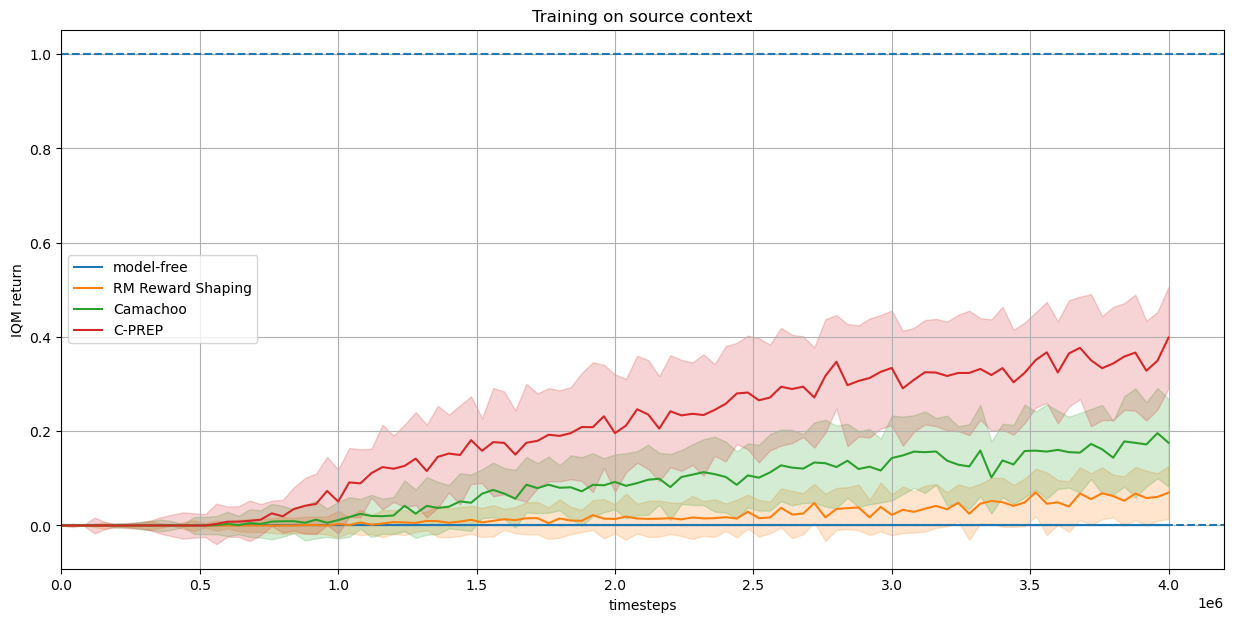

In [17]:
h.plot_experiments_eval(
    experiments_idx=[2, 1, 3, 4],
    plot_kwargs_per_idx=[
        dict(label="model-free"),
        dict(label="RM Reward Shaping"),
        dict(label="Camachoo"),
        dict(label="C-PREP"),
    ],
    cfg_constraints=constraint,
    exp_agg_type='seed',
    record_median=False,
    record_iqm=True,
    record_returns=True,
    with_deviation=True,
    src_xlim=(0, None),
    tgt_xlim=None,
    l_bound=0,
    u_bound=1,
    show_src_scratch=True,
    show_src_test=False,
    show_tgt_scratch=True,
    show_tgt_transfer=True,
    save_path='2-passengers.pdf'
)

In [ ]:
exp_num = 2753

(src_context, src_train_env, src_eval_env, src_agent,
                tgt_context, tgt_train_env, tgt_eval_env, tgt_agent,
                tsf_agent) = h.get_experiment_contexts_envs_and_agents(exp_num)

In [ ]:
src_train_env.reset()
src_train_env.render()